In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
from datetime import datetime
import tqdm


from ann import NeuralNetwork
from pso import PSO
from pso_ann_trainer import rmse, create_fitness_function, to_numpy


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print(" All imports successful!")

 All imports successful!


In [44]:
# Load data
repo_root = Path.cwd().parent  
data_dir = repo_root / 'data'
npz_path = data_dir / 'processed_data.npz'

print(f"Loading data from {npz_path}...")
data = np.load(npz_path, allow_pickle=True)
X_train = to_numpy(data['X_train'])
X_test = to_numpy(data['X_test'])
y_train = to_numpy(data['y_train']).ravel()
y_test = to_numpy(data['y_test']).ravel()

print(f"✓ Training data: {X_train.shape}")
print(f"✓ Test data: {X_test.shape}")
print(f"✓ n_features: {X_train.shape[1]}")

Loading data from /Users/gayathridinesh/Documents/GitHub/F21BC_Coursework/data/processed_data.npz...
✓ Training data: (721, 8)
✓ Test data: (309, 8)
✓ n_features: 8


10 experiments with varying PSO and ANN parameters

In [45]:
n_features = X_train.shape[1]

experiment_configs = [
    {
        "exp_id": 1,
        "seed": 42,
        "layer_sizes": [n_features, 128, 64, 32, 1],
        "activations": ['relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 25,
        "pso_iterations": 50,
        "pso_bounds": (-5.0, 5.0)
    },
    {
        "exp_id": 2,
        "seed": 123,
        "layer_sizes": [n_features, 256, 128, 64, 32, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 30,
        "pso_iterations": 60,
        "pso_bounds": (-4.0, 4.0)
    },
    {
        "exp_id": 3,
        "seed": 456,
        "layer_sizes": [n_features, 200, 150, 100, 50, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 35,
        "pso_iterations": 70,
        "pso_bounds": (-3.5, 3.5)
    },
    {
        "exp_id": 4,
        "seed": 789,
        "layer_sizes": [n_features, 300, 200, 128, 64, 32, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 40,
        "pso_iterations": 80,
        "pso_bounds": (-3.0, 3.0)
    },
    {
        "exp_id": 5,
        "seed": 999,
        "layer_sizes": [n_features, 250, 200, 150, 100, 50, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 38,
        "pso_iterations": 75,
        "pso_bounds": (-3.0, 3.0)
    },
    {
        "exp_id": 6,
        "seed": 111,
        "layer_sizes": [n_features, 180, 120, 80, 40, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 32,
        "pso_iterations": 65,
        "pso_bounds": (-4.0, 4.0)
    },
    {
        "exp_id": 7,
        "seed": 222,
        "layer_sizes": [n_features, 160, 128, 96, 64, 32, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 36,
        "pso_iterations": 72,
        "pso_bounds": (-3.5, 3.5)
    },
    {
        "exp_id": 8,
        "seed": 333,
        "layer_sizes": [n_features, 224, 168, 112, 56, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 33,
        "pso_iterations": 68,
        "pso_bounds": (-3.5, 3.5)
    },
    {
        "exp_id": 9,
        "seed": 444,
        "layer_sizes": [n_features, 320, 240, 160, 80, 40, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 42,
        "pso_iterations": 85,
        "pso_bounds": (-2.8, 2.8)
    },
    {
        "exp_id": 10,
        "seed": 555,
        "layer_sizes": [n_features, 192, 144, 108, 72, 36, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 39,
        "pso_iterations": 78,
        "pso_bounds": (-3.2, 3.2)
    }
]

print(f"Configured {len(experiment_configs)} experiments")
for cfg in experiment_configs:
    print(f"  Exp {cfg['exp_id']}: layers={cfg['layer_sizes']}, swarm={cfg['pso_swarm_size']}, iters={cfg['pso_iterations']}")

Configured 10 experiments
  Exp 1: layers=[8, 128, 64, 32, 1], swarm=25, iters=50
  Exp 2: layers=[8, 256, 128, 64, 32, 1], swarm=30, iters=60
  Exp 3: layers=[8, 200, 150, 100, 50, 1], swarm=35, iters=70
  Exp 4: layers=[8, 300, 200, 128, 64, 32, 1], swarm=40, iters=80
  Exp 5: layers=[8, 250, 200, 150, 100, 50, 1], swarm=38, iters=75
  Exp 6: layers=[8, 180, 120, 80, 40, 1], swarm=32, iters=65
  Exp 7: layers=[8, 160, 128, 96, 64, 32, 1], swarm=36, iters=72
  Exp 8: layers=[8, 224, 168, 112, 56, 1], swarm=33, iters=68
  Exp 9: layers=[8, 320, 240, 160, 80, 40, 1], swarm=42, iters=85
  Exp 10: layers=[8, 192, 144, 108, 72, 36, 1], swarm=39, iters=78


In [46]:
def run_single_experiment(config, X_train, X_test, y_train, y_test):
    """Run a single PSO-ANN experiment."""
    exp_id = config['exp_id']
    seed = config['seed']
    
    np.random.seed(seed)
    
    net = NeuralNetwork(config['layer_sizes'], config['activations'])
    n_params = net.get_parameter_count()
    
    # Initial evaluation
    y_pred_init = net.predict(X_train)
    if y_pred_init.ndim > 1:
        y_pred_init = y_pred_init.ravel()
    rmse_init = rmse(y_train, y_pred_init)
    
    # Fitness function
    fitness_func = create_fitness_function(net, X_train, y_train)
    
    # Run PSO
    # Use bounds scaled by network size for better convergence
    bound_scale = 1.0 / np.sqrt(n_params)
    bound_scale = np.clip(bound_scale, 0.5, 2.0)  
    
    pso = PSO(
        objective_function=fitness_func,
        dimension=n_params,
        swarm_size=config['pso_swarm_size'],
        num_informants=3,
        w=0.7,   # Inertia weight
        c1=1.5,  # Cognitive component
        c2=1.5,  # Social component
        bounds=(-bound_scale, bound_scale),  
        max_iterations=config['pso_iterations']
    )
    
    best_params, best_fitness, fitness_history = pso.optimize(verbose=False)
    
    # DEBUG: Print optimization info
    print(f"\n DEBUG INFO FOR EXPERIMENT {exp_id}:")
    print(f"Initial RMSE: {rmse_init:.4f}")
    print(f"PSO best fitness (final): {best_fitness:.4f}")
    print(f"Fitness history - First 5 iterations: {[f'{x:.4f}' for x in fitness_history[:5]]}")
    print(f"Fitness history - Last 5 iterations: {[f'{x:.4f}' for x in fitness_history[-5:]]}")
    
    # Apply best parameters and evaluate
    net.set_parameters(best_params)
    y_pred_train = net.predict(X_train)
    if y_pred_train.ndim > 1:
        y_pred_train = y_pred_train.ravel()
    rmse_train = rmse(y_train, y_pred_train)
    
    y_pred_test = net.predict(X_test)
    if y_pred_test.ndim > 1:
        y_pred_test = y_pred_test.ravel()
    rmse_test = rmse(y_test, y_pred_test)
    
    improvement = (rmse_init - rmse_train) / rmse_init * 100
    print(f"Improvement: {improvement:.1f}%\n")
    
    return {
        'exp_id': exp_id,
        'seed': seed,
        'architecture': str(config['layer_sizes']),
        'n_parameters': n_params,
        'rmse_initial': rmse_init,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'improvement_pct': improvement,
        'fitness_history': fitness_history
    }

print("Utility functions loaded from pso_ann_trainer")

Utility functions loaded from pso_ann_trainer


In [47]:
# Reset results and start fresh
results = []

exp_result_1 = run_single_experiment(experiment_configs[0], X_train, X_test, y_train, y_test)
results.append(exp_result_1)
print(f"Exp 1 Complete: Train RMSE={exp_result_1['rmse_train']:.4f}, Test RMSE={exp_result_1['rmse_test']:.4f}, Improvement={exp_result_1['improvement_pct']:.1f}%")


 DEBUG INFO FOR EXPERIMENT 1:
Initial RMSE: 39.4446
PSO best fitness (final): 14.5972
Fitness history - First 5 iterations: ['37.3595', '31.8461', '24.4891', '22.1657', '20.6900']
Fitness history - Last 5 iterations: ['14.7639', '14.7208', '14.7054', '14.6775', '14.5972']
Improvement: 63.0%

Exp 1 Complete: Train RMSE=14.5972, Test RMSE=14.9724, Improvement=63.0%


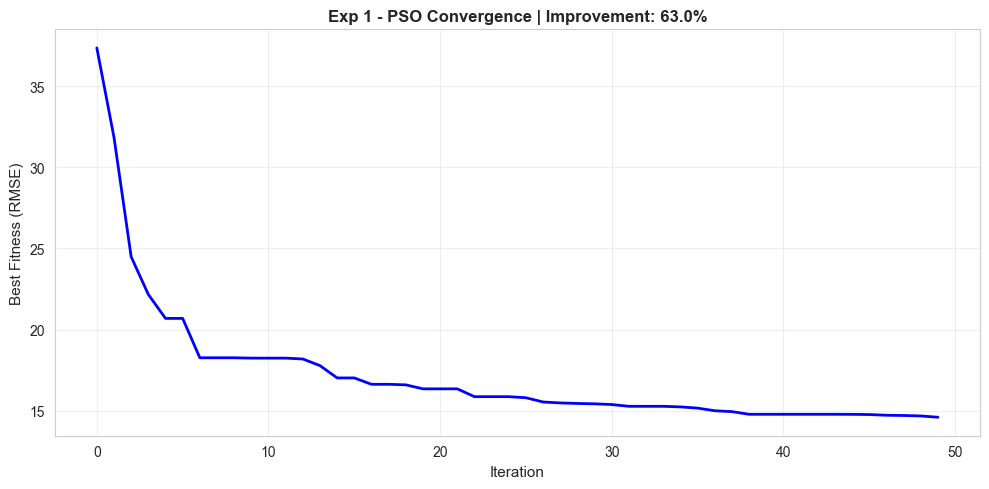

In [48]:
# Visualization for Experiment 1
plt.figure(figsize=(10, 5))
plt.plot(exp_result_1['fitness_history'], 'b-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 1 - PSO Convergence | Improvement: {exp_result_1['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [49]:
exp_result_2 = run_single_experiment(experiment_configs[1], X_train, X_test, y_train, y_test)
results.append(exp_result_2)
print(f"Exp 2 Complete: Train RMSE={exp_result_2['rmse_train']:.4f}, Test RMSE={exp_result_2['rmse_test']:.4f}, Improvement={exp_result_2['improvement_pct']:.1f}%")


 DEBUG INFO FOR EXPERIMENT 2:
Initial RMSE: 39.9812
PSO best fitness (final): 14.5815
Fitness history - First 5 iterations: ['23.5780', '22.2584', '22.2584', '20.9478', '20.9478']
Fitness history - Last 5 iterations: ['14.8625', '14.8049', '14.7899', '14.5815', '14.5815']
Improvement: 63.5%

Exp 2 Complete: Train RMSE=14.5815, Test RMSE=14.8532, Improvement=63.5%


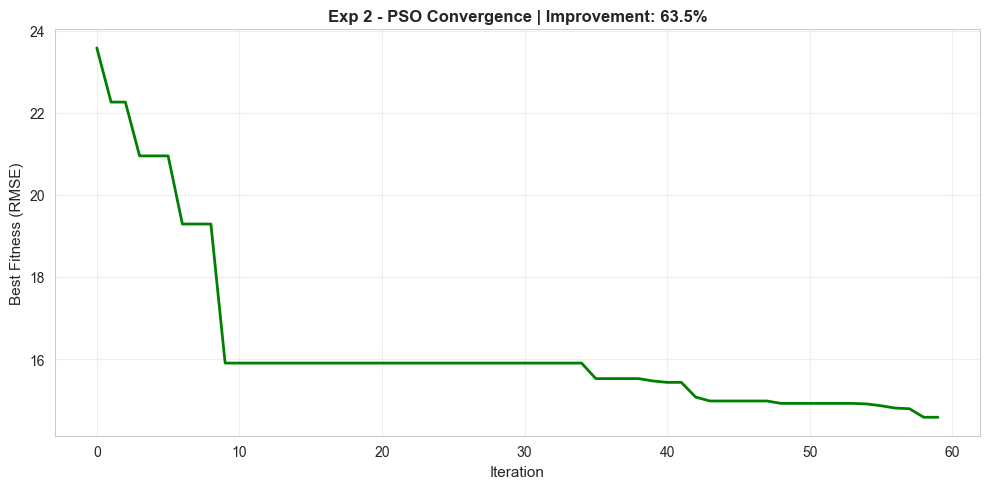

In [50]:
# Visualization for Experiment 2
plt.figure(figsize=(10, 5))
plt.plot(exp_result_2['fitness_history'], 'g-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 2 - PSO Convergence | Improvement: {exp_result_2['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [51]:
exp_result_3 = run_single_experiment(experiment_configs[2], X_train, X_test, y_train, y_test)
results.append(exp_result_3)
print(f"Exp 3 Complete: Train RMSE={exp_result_3['rmse_train']:.4f}, Test RMSE={exp_result_3['rmse_test']:.4f}, Improvement={exp_result_3['improvement_pct']:.1f}%")


 DEBUG INFO FOR EXPERIMENT 3:
Initial RMSE: 40.8191
PSO best fitness (final): 14.7535
Fitness history - First 5 iterations: ['21.3051', '21.3051', '21.3051', '20.0181', '20.0181']
Fitness history - Last 5 iterations: ['14.7621', '14.7611', '14.7611', '14.7598', '14.7535']
Improvement: 63.9%

Exp 3 Complete: Train RMSE=14.7535, Test RMSE=14.6670, Improvement=63.9%


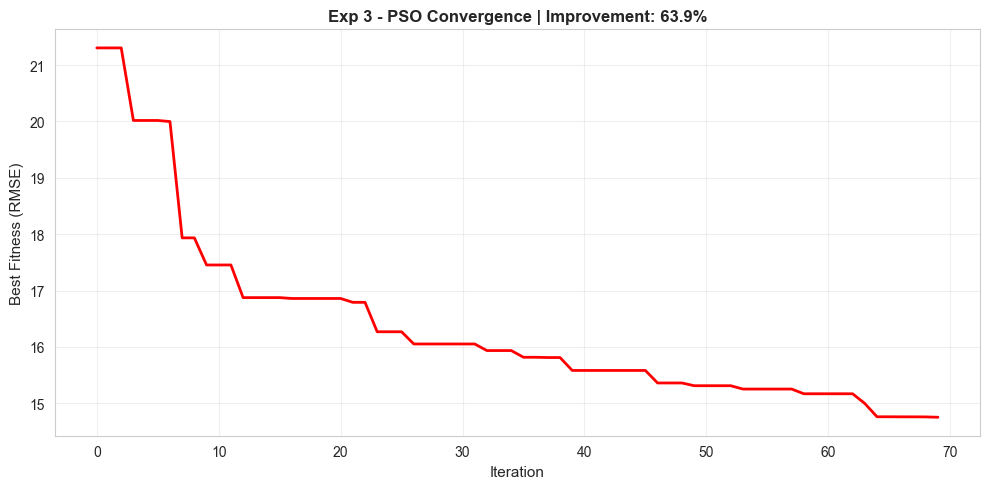

In [52]:
# Visualization for Experiment 3
plt.figure(figsize=(10, 5))
plt.plot(exp_result_3['fitness_history'], 'r-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 3 - PSO Convergence | Improvement: {exp_result_3['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [53]:
exp_result_4 = run_single_experiment(experiment_configs[3], X_train, X_test, y_train, y_test)
results.append(exp_result_4)
print(f"Exp 4 Complete: Train RMSE={exp_result_4['rmse_train']:.4f}, Test RMSE={exp_result_4['rmse_test']:.4f}, Improvement={exp_result_4['improvement_pct']:.1f}%")


 DEBUG INFO FOR EXPERIMENT 4:
Initial RMSE: 39.5532
PSO best fitness (final): 14.7223
Fitness history - First 5 iterations: ['22.9708', '22.9708', '22.9708', '22.9708', '22.9708']
Fitness history - Last 5 iterations: ['15.1870', '14.7223', '14.7223', '14.7223', '14.7223']
Improvement: 62.8%

Exp 4 Complete: Train RMSE=14.7223, Test RMSE=14.6485, Improvement=62.8%


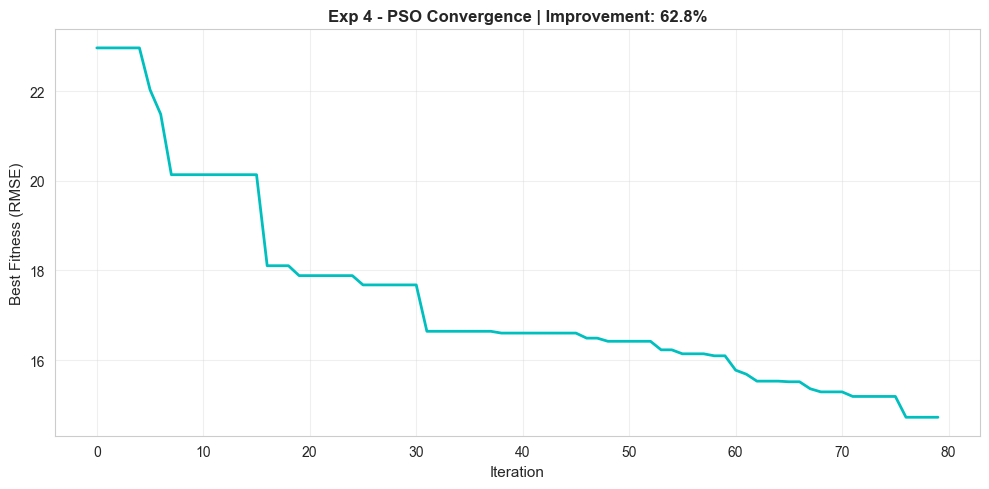

In [54]:
# Visualization for Experiment 4
plt.figure(figsize=(10, 5))
plt.plot(exp_result_4['fitness_history'], 'c-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 4 - PSO Convergence | Improvement: {exp_result_4['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [55]:
exp_result_5 = run_single_experiment(experiment_configs[4], X_train, X_test, y_train, y_test)
results.append(exp_result_5)
print(f"Exp 5 Complete: Train RMSE={exp_result_5['rmse_train']:.4f}, Test RMSE={exp_result_5['rmse_test']:.4f}, Improvement={exp_result_5['improvement_pct']:.1f}%")


 DEBUG INFO FOR EXPERIMENT 5:
Initial RMSE: 40.6740
PSO best fitness (final): 15.5662
Fitness history - First 5 iterations: ['24.7853', '23.0654', '22.4421', '22.4421', '19.5819']
Fitness history - Last 5 iterations: ['15.5662', '15.5662', '15.5662', '15.5662', '15.5662']
Improvement: 61.7%

Exp 5 Complete: Train RMSE=15.5662, Test RMSE=15.3644, Improvement=61.7%


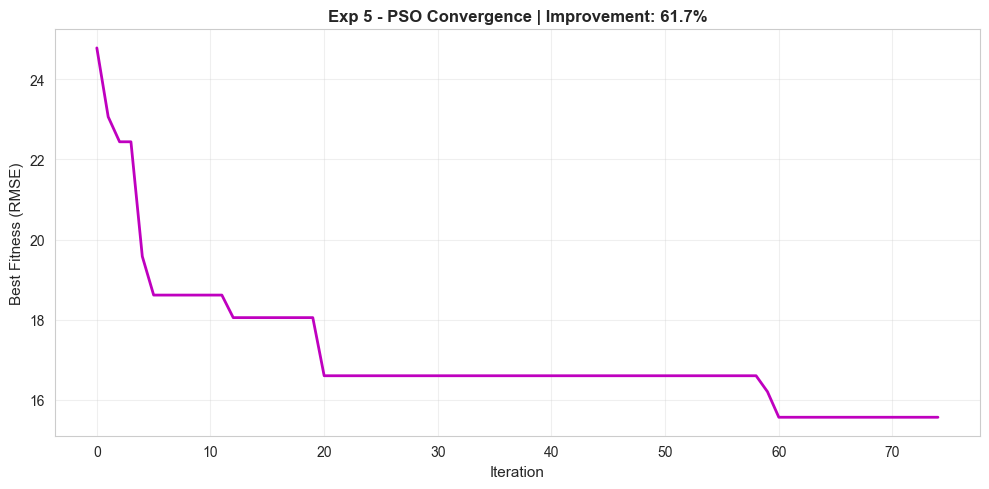

In [56]:
# Visualization for Experiment 5
plt.figure(figsize=(10, 5))
plt.plot(exp_result_5['fitness_history'], 'm-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 5 - PSO Convergence | Improvement: {exp_result_5['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [70]:
exp_result_6 = run_single_experiment(experiment_configs[5], X_train, X_test, y_train, y_test)
results.append(exp_result_6)
print(f"Exp 6 Complete: Train RMSE={exp_result_6['rmse_train']:.4f}, Test RMSE={exp_result_6['rmse_test']:.4f}, Improvement={exp_result_6['improvement_pct']:.1f}%")


 DEBUG INFO FOR EXPERIMENT 6:
Initial RMSE: 39.6564
PSO best fitness (final): 14.2342
Fitness history - First 5 iterations: ['18.8110', '18.8110', '18.8110', '18.8110', '16.9067']
Fitness history - Last 5 iterations: ['14.2818', '14.2567', '14.2567', '14.2560', '14.2342']
Improvement: 64.1%

Exp 6 Complete: Train RMSE=14.2342, Test RMSE=14.6958, Improvement=64.1%


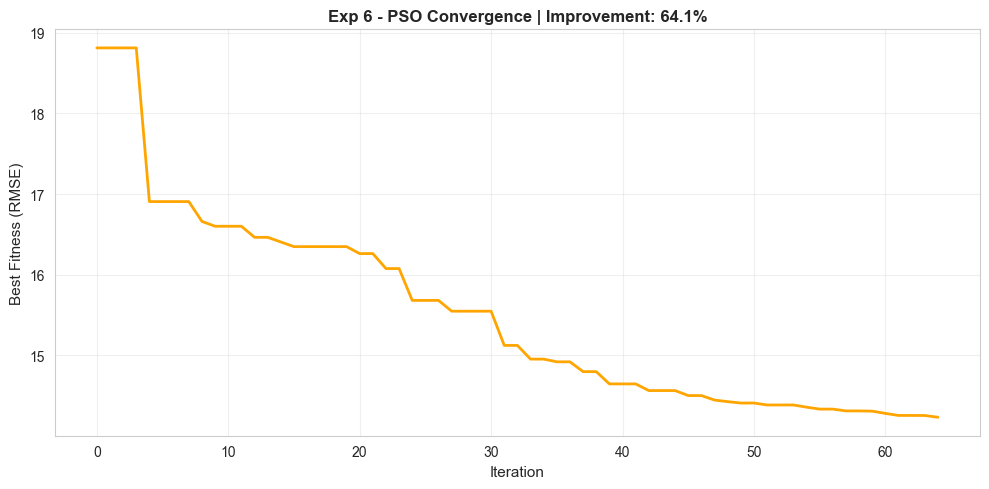

In [71]:
# Visualization for Experiment 6
plt.figure(figsize=(10, 5))
plt.plot(exp_result_6['fitness_history'], 'orange', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 6 - PSO Convergence | Improvement: {exp_result_6['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [72]:
exp_result_7 = run_single_experiment(experiment_configs[6], X_train, X_test, y_train, y_test)
results.append(exp_result_7)
print(f" Exp 7 Complete: Train RMSE={exp_result_7['rmse_train']:.4f}, Test RMSE={exp_result_7['rmse_test']:.4f}, Improvement={exp_result_7['improvement_pct']:.1f}%")


 DEBUG INFO FOR EXPERIMENT 7:
Initial RMSE: 40.6152
PSO best fitness (final): 14.3010
Fitness history - First 5 iterations: ['21.5270', '21.5270', '21.5270', '21.5270', '21.4150']
Fitness history - Last 5 iterations: ['14.4376', '14.4376', '14.3010', '14.3010', '14.3010']
Improvement: 64.8%

 Exp 7 Complete: Train RMSE=14.3010, Test RMSE=14.2488, Improvement=64.8%


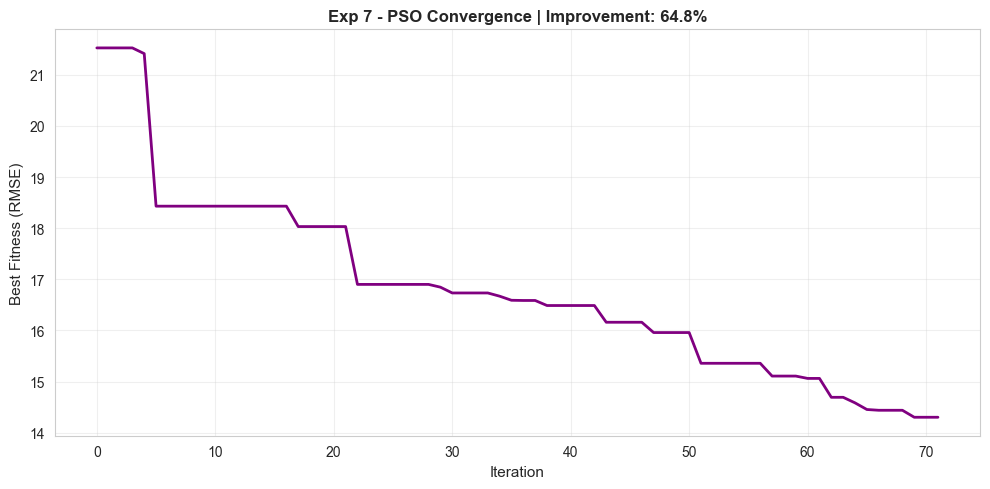

In [73]:
# Visualization for Experiment 7
plt.figure(figsize=(10, 5))
plt.plot(exp_result_7['fitness_history'], 'purple', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 7 - PSO Convergence | Improvement: {exp_result_7['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [74]:
exp_result_8 = run_single_experiment(experiment_configs[7], X_train, X_test, y_train, y_test)
results.append(exp_result_8)
print(f" Exp 8 Complete: Train RMSE={exp_result_8['rmse_train']:.4f}, Test RMSE={exp_result_8['rmse_test']:.4f}, Improvement={exp_result_8['improvement_pct']:.1f}%")


 DEBUG INFO FOR EXPERIMENT 8:
Initial RMSE: 40.0934
PSO best fitness (final): 13.5087
Fitness history - First 5 iterations: ['21.3107', '21.3107', '21.3107', '20.5881', '20.5881']
Fitness history - Last 5 iterations: ['13.8292', '13.8292', '13.8292', '13.6698', '13.5087']
Improvement: 66.3%

 Exp 8 Complete: Train RMSE=13.5087, Test RMSE=13.4701, Improvement=66.3%


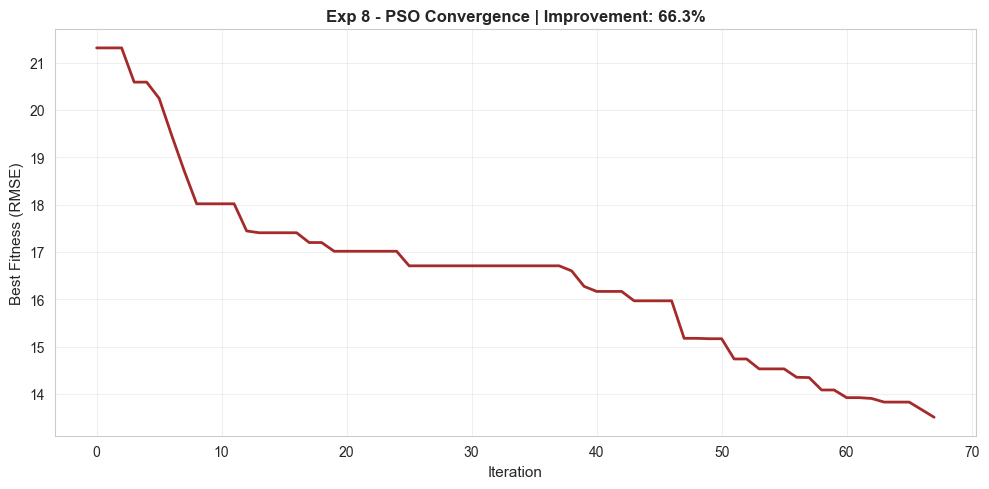

In [75]:
# Visualization for Experiment 8
plt.figure(figsize=(10, 5))
plt.plot(exp_result_8['fitness_history'], 'brown', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 8 - PSO Convergence | Improvement: {exp_result_8['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [76]:
exp_result_9 = run_single_experiment(experiment_configs[8], X_train, X_test, y_train, y_test)
results.append(exp_result_9)
print(f" Exp 9 Complete: Train RMSE={exp_result_9['rmse_train']:.4f}, Test RMSE={exp_result_9['rmse_test']:.4f}, Improvement={exp_result_9['improvement_pct']:.1f}%")


 DEBUG INFO FOR EXPERIMENT 9:
Initial RMSE: 40.7467
PSO best fitness (final): 13.6246
Fitness history - First 5 iterations: ['25.4357', '17.4634', '17.4634', '17.4634', '17.4634']
Fitness history - Last 5 iterations: ['13.7198', '13.6500', '13.6500', '13.6246', '13.6246']
Improvement: 66.6%

 Exp 9 Complete: Train RMSE=13.6246, Test RMSE=13.2873, Improvement=66.6%


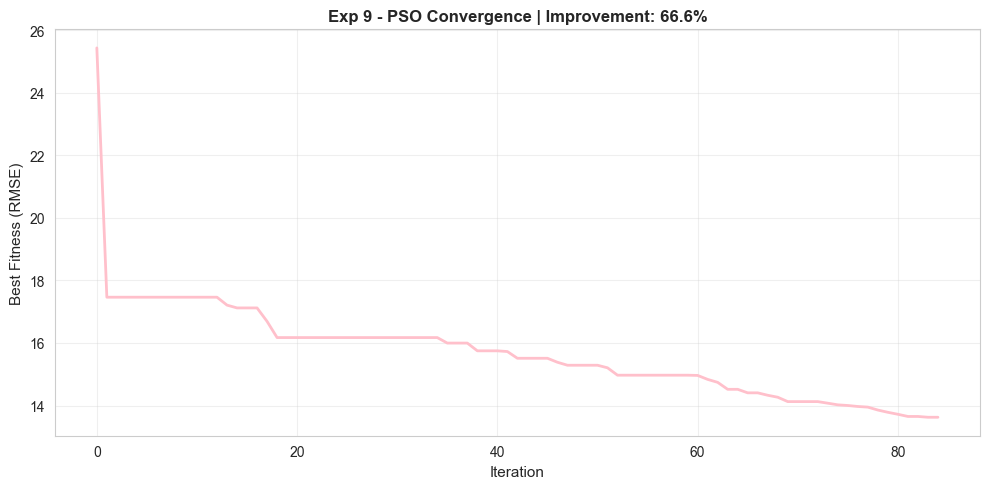

In [77]:
# Visualization for Experiment 9
plt.figure(figsize=(10, 5))
plt.plot(exp_result_9['fitness_history'], 'pink', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 9 - PSO Convergence | Improvement: {exp_result_9['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [78]:
exp_result_10 = run_single_experiment(experiment_configs[9], X_train, X_test, y_train, y_test)
results.append(exp_result_10)
print(f"Exp 10 Complete: Train RMSE={exp_result_10['rmse_train']:.4f}, Test RMSE={exp_result_10['rmse_test']:.4f}, Improvement={exp_result_10['improvement_pct']:.1f}%")




 DEBUG INFO FOR EXPERIMENT 10:
Initial RMSE: 40.3706
PSO best fitness (final): 13.5804
Fitness history - First 5 iterations: ['21.8588', '21.8588', '21.8588', '20.7272', '20.7272']
Fitness history - Last 5 iterations: ['13.8642', '13.8184', '13.7925', '13.5804', '13.5804']
Improvement: 66.4%

Exp 10 Complete: Train RMSE=13.5804, Test RMSE=13.2445, Improvement=66.4%


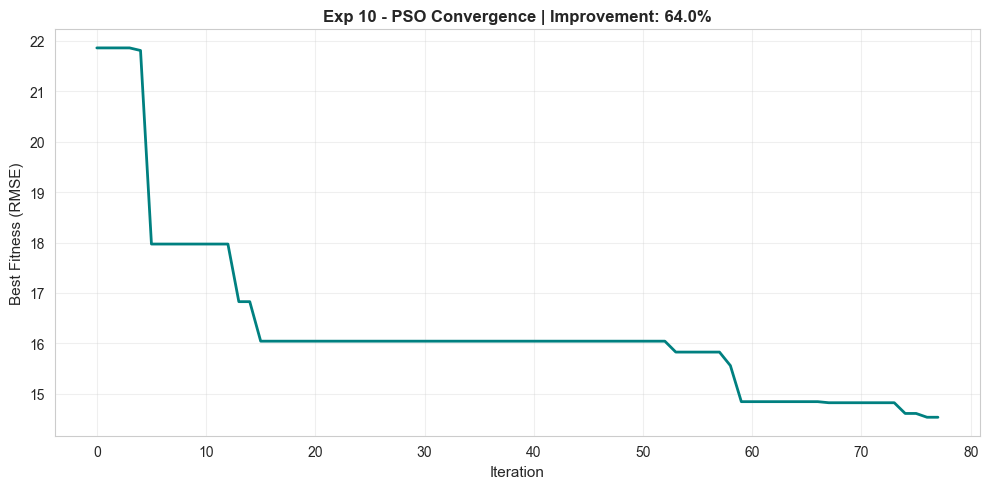

In [66]:
# Visualization for Experiment 10
plt.figure(figsize=(10, 5))
plt.plot(exp_result_10['fitness_history'], 'teal', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 10 - PSO Convergence | Improvement: {exp_result_10['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [80]:
print("ALL 10 EXPERIMENTS COMPLETED!")


ALL 10 EXPERIMENTS COMPLETED!


In [82]:
# Create results dataframe
results_df = pd.DataFrame(results)
print("EXPERIMENT RESULTS SUMMARY")
print(results_df[['exp_id', 'n_parameters', 'rmse_initial', 'rmse_train', 'rmse_test', 'improvement_pct']].to_string(index=False))


EXPERIMENT RESULTS SUMMARY
 exp_id  n_parameters  rmse_initial  rmse_train  rmse_test  improvement_pct
      1         11521     39.444648   14.597236  14.972393        62.993113
      2         45569     39.981178   14.581517  14.853172        63.529046
      3         52151     40.819079   14.753502  14.666993        63.856358
      4         98997     39.553249   14.722324  14.648508        62.778471
      5        102801     40.673951   15.566157  15.364372        61.729420
      6         36301     39.656363   13.983785  13.984153        64.737602
      7         42753     40.615167   15.376991  15.044927        62.139782
      8         65129     40.093433   14.148038  14.475568        64.712330
      9        134641     40.746721   13.521403  14.334748        66.815972
     10         55693     40.370586   14.535621  14.249592        63.994526
      6         36301     39.656363   14.234240  14.695816        64.106038
      7         42753     40.615167   14.300983  14.248841   

In [84]:
# Create results directory 
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

# Save CSV
csv_path = results_dir / 'experiment_results.csv'
results_df[['exp_id', 'n_parameters', 'rmse_initial', 'rmse_train', 'rmse_test', 'improvement_pct']].to_csv(csv_path, index=False)

# Save detailed JSON
json_data = {
    'timestamp': datetime.now().isoformat(),
    'num_experiments': len(results),
    'statistics': {
        'mean_train_rmse': float(results_df['rmse_train'].mean()),
        'std_train_rmse': float(results_df['rmse_train'].std()),
        'mean_test_rmse': float(results_df['rmse_test'].mean()),
        'std_test_rmse': float(results_df['rmse_test'].std()),
        'mean_improvement_pct': float(results_df['improvement_pct'].mean()),
    },
    'experiments': []
}

for result in results:
    exp_dict = {
        'exp_id': result['exp_id'],
        'seed': result['seed'],
        'architecture': result['architecture'],
        'n_parameters': result['n_parameters'],
        'rmse_initial': float(result['rmse_initial']),
        'rmse_train': float(result['rmse_train']),
        'rmse_test': float(result['rmse_test']),
        'improvement_pct': float(result['improvement_pct']),
        'fitness_history_length': len(result['fitness_history'])
    }
    json_data['experiments'].append(exp_dict)

json_path = results_dir / 'experiment_results.json'
with open(json_path, 'w') as f:
    json.dump(json_data, f, indent=2)

print(f"Results saved to:")
print(f"   CSV: {csv_path}")
print(f"   JSON: {json_path}")
print(f"\nSummary Statistics:")
print(f"   Mean Train RMSE: {results_df['rmse_train'].mean():.4f} ± {results_df['rmse_train'].std():.4f}")
print(f"   Mean Test RMSE:  {results_df['rmse_test'].mean():.4f} ± {results_df['rmse_test'].std():.4f}")
print(f"   Mean Improvement: {results_df['improvement_pct'].mean():.2f}%")

Results saved to:
   CSV: ../results/experiment_results.csv
   JSON: ../results/experiment_results.json

Summary Statistics:
   Mean Train RMSE: 14.3357 ± 0.6372
   Mean Test RMSE:  14.3694 ± 0.6410
   Mean Improvement: 64.36%
